In [1]:
import json, os, sys
%load_ext autoreload
%autoreload 2
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# from utils import session_config
# session_config.setup_gpus(True, 0.95)

from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from functools import partial
from utils.iou import compute_iou

# load image information from coco object

In [2]:
sys.path.append("/home/files/cocoapi/PythonAPI")
from pycocotools.coco import COCO
coco = COCO("annotations/integrated_annotation.json")

train_ids = np.load("annotations/train_ids.npy")
print("train-data length : {}".format(len(train_ids)))
val_ids = np.load("annotations/val_ids.npy")
print("train-data length : {}".format(len(val_ids)))

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
train-data length : 8995
train-data length : 1737


In [3]:
boxes = np.zeros([19,4])
for i in range(19):
    boxes[i] = [0,0+0.05*i,1,0.1+0.05*i]

def label_process(image_id):
    anno_ids = coco.getAnnIds(imgIds=int(image_id), catIds=[0], iscrowd=None)
    anns = coco.loadAnns(anno_ids)
    bbox = []
    for ann in anns:
        x,y,w,h = ann["bbox"]
        x,y,w,h = x/2024,y/10000,w/2024,h/10000    
        bbox.append([x,y,x+w,y+h]) 
    bbox = np.array(bbox)        
    ious = compute_iou(bbox, boxes)         
    ious = np.sum(ious, axis=0)
    ious = tf.squeeze(ious)
    labels = tf.where(ious>0, 1, 0) 
    return labels

def data_process(image_ids):
    image_ids = image_ids.numpy()
    image_array = []
    label_array = []
    for image_id in image_ids:
        image = coco.loadImgs(int(image_id))      
        image_array.append(cv2.imread("detection" + image[0]["path"])[:,:,::-1])
        label_array.append(label_process(image_id))
    image_array = np.array(image_array, np.uint8)
    patches = tf.image.extract_patches(images=image_array,
                                 sizes=[1, 1000, 1024, 1],
                                 strides=[1, 500, 1, 1],
                                 rates=[1, 1, 1, 1],
                                 padding='VALID')
    patches = tf.squeeze(patches)
    patches = tf.reshape(patches, (-1, 1000,1024,3))
    patches = tf.cast(patches, tf.float32)
    patches = tf.keras.applications.resnet_v2.preprocess_input(patches)
    patches = tf.image.resize(patches, (224,224), method="area")
    label_array = np.array(label_array, np.int32)
    label_array = tf.reshape(label_array, (-1))
    return patches, label_array


In [4]:
batch_size = 6; AUTOTUNE = tf.data.experimental.AUTOTUNE;
train_ds = tf.data.Dataset.from_tensor_slices(train_ids).cache().shuffle(1000).batch(batch_size)
train_ds = train_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(val_ids).cache().batch(batch_size)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)


for img, label in train_ds.take(1):
    print(img.shape, label)
    
for img, label in val_ds.take(1):
    print(img.shape, label)

(114, 224, 224, 3) tf.Tensor(
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0], shape=(114,), dtype=int32)
(114, 224, 224, 3) tf.Tensor(
[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 0 0], shape=(114,), dtype=int32)


# 모델 빌드 및 학습

In [ ]:
resnet = tf.keras.applications.ResNet50V2(include_top=False, 
                                         weights='imagenet', 
                                         input_shape=(224,224,3))

In [ ]:
model = tf.keras.Sequential([resnet,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(2, activation=None),
                             tf.keras.layers.Softmax()])                             

In [ ]:
@tf.function
def train_step(images, labels, model, optimizer, train_loss, train_acc):
    with tf.GradientTape() as tape:
        preds = model(images, training=True)
        loss = loss_object(labels,preds)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_acc(labels, preds)
@tf.function
def test_step(images, labels, model):
    preds = model(images, training=False)
    loss = loss_object(labels,preds)
    test_loss(loss)
    test_acc(labels, preds)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
template = "Epoch {} : train loss {:5f}, accuracy {:.3f}, val loss {:5f}, val accuracy {:.3f}"

optimizer = tf.keras.optimizers.Adam(learning_rate=1E-3)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
EPOCH = 20

log_dir = "logs/detection_test_v1"
summary_writer = tf.summary.create_file_writer(log_dir)

for epoch in range(1, EPOCH+1):
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    for i, (imgs, labels) in enumerate(train_ds):
        train_step(imgs, labels, model, optimizer, train_loss, train_acc)
    for imgs, labels in val_ds:
        test_step(imgs, labels, model)
    print(template.format(epoch,
                          train_loss.result().numpy(),
                          train_acc.result().numpy(),
                         test_loss.result().numpy(),
                         test_acc.result().numpy()))

    with summary_writer.as_default():
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
        tf.summary.scalar('train_acc', train_acc.result().numpy(), step=epoch)
        tf.summary.scalar('test_loss', test_loss.result().numpy(), step=epoch)
        tf.summary.scalar('test_acc', test_acc.result().numpy(), step=epoch)

In [ ]:
model.save("checkpoints/detection_test_v1/model.h5")

# 테스트

In [8]:
model = tf.keras.models.load_modelval_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
("checkpoints/detection_test_v1/model.h5")

In [9]:
val_ds = tf.data.Dataset.from_tensor_slices(val_ids).cache().batch(1)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)

In [10]:
for img, label in val_ds.take(1):
    print(img.shape)
    print(label)

(19, 224, 224, 3)
tf.Tensor([0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0], shape=(19,), dtype=int32)


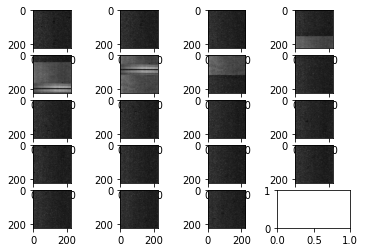

In [25]:
fig = plt.figure()

for r in range(5):
    for c in range(4):
        ax = fig.add_subplot(5,4,r*4 + c + 1)
        if r*4+c+1>19:
            break
        ax.imshow((img[r*4+c]+1)/2)

In [26]:
model(img)

<tf.Tensor: shape=(19, 2), dtype=float32, numpy=
array([[9.9999893e-01, 1.1264302e-06],
       [9.9998701e-01, 1.2999911e-05],
       [9.9999821e-01, 1.8072346e-06],
       [9.9913788e-01, 8.6204411e-04],
       [1.4948235e-11, 1.0000000e+00],
       [1.1479960e-07, 9.9999988e-01],
       [6.7583849e-03, 9.9324167e-01],
       [9.9981350e-01, 1.8657075e-04],
       [9.9999762e-01, 2.4125407e-06],
       [9.9999917e-01, 8.3362897e-07],
       [9.9999344e-01, 6.5348572e-06],
       [9.9999166e-01, 8.3270625e-06],
       [9.9999762e-01, 2.3261084e-06],
       [9.9999809e-01, 1.9546194e-06],
       [9.9999917e-01, 8.9288073e-07],
       [9.9999893e-01, 1.1130076e-06],
       [9.9999797e-01, 2.0063446e-06],
       [9.9999619e-01, 3.7851951e-06],
       [9.9999738e-01, 2.6224086e-06]], dtype=float32)>